# Neural Network Quantum State



In [1]:
import os
import json
import time

import pandas as pd
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import flax
import ray
# import flax.linen as nn
import netket as nk
import netket.nn as nn

from scipy.sparse.linalg import eigsh
from netket.operator.spin import sigmaz, sigmax 
from ray import tune
from tqdm.autonotebook import tqdm
from IPython.display import display

# Our source code
from model import OurModel, setup_problem, setup_model, ray_train_loop

<ipython-input-1-a8820b2d62cf>:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
os.environ["JAX_PLATFORM_NAME"] = "cpu" # or gpu
# os.environ["RAY_PICKLE_VERBOSE_DEBUG"] = "1" # RAY DEBUG
# os.environ["XLA_FLAGS"] = "--xla_gpu_force_compilation_parallelism=1"  # force gpu w/o right drivers

skip_training = False
print(f'{nk.utils.mpi.available=}')

# Force detecting GPU in WSL
ray.shutdown()
ray.init(num_gpus=1)

nk.utils.mpi.available=False


RayContext(dashboard_url='', python_version='3.9.1', ray_version='1.12.0', ray_commit='f18fc31c7562990955556899090f8e8656b48d2d', address_info={'node_ip_address': '127.0.0.1', 'raylet_ip_address': '127.0.0.1', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-05-16_17-32-15_972185_64790/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-05-16_17-32-15_972185_64790/sockets/raylet', 'webui_url': '', 'session_dir': '/tmp/ray/session_2022-05-16_17-32-15_972185_64790', 'metrics_export_port': 60210, 'gcs_address': '127.0.0.1:60277', 'address': '127.0.0.1:60277', 'node_id': 'b19df83d78c01ccbf860df4dea6636f76a005f135ced10939e1eae27'})

In [3]:
if not skip_training:
    from ray.tune.suggest.hyperopt import HyperOptSearch
    
    search_space = {
        'model': {
            'alpha': tune.randint(1, 3+1), # last value exclusive
        },
        # 'activation': tune.choice(['tanh', 'sigmoid']),
        'learning_rate': tune.uniform(0.0, 0.1),
        'n_epochs': 300, #tune.qrandint(100, 300, 50),
        'n_samples': 1008, #tune.qrandint(100, 1000, 100),
    }
    
    metric = "energy_error"
    mode = "min"

    hyperopt_search = HyperOptSearch(metric=metric, mode=mode)
    hyper_band_scheduler = tune.schedulers.ASHAScheduler(
        metric=metric,
        mode=mode,
        max_t=search_space['n_epochs'].max_value if isinstance(search_space['n_epochs'], tune.sample.Sampler) else search_space['n_epochs'],
        grace_period=20
    )

    analysis = tune.run(
        ray_train_loop,
        config=search_space,
        progress_reporter=tune.JupyterNotebookReporter(True, [metric]),
        scheduler=hyper_band_scheduler,
        resources_per_trial={"cpu": 6, 'gpu': 1/2},
        search_alg=hyperopt_search,
        num_samples=10,
        resume='AUTO',
        # metric=metric,
        # mode=mode,
    )

Trial name,status,loc,learning_rate,model/alpha,n_epochs,n_samples
ray_train_loop_008e3620,PENDING,,0.0996338,2,300,1008


2022-05-16 17:35:50,670	ERROR tune.py:697 -- Trials did not complete: [ray_train_loop_008e3620]
2022-05-16 17:35:50,672	INFO tune.py:701 -- Total run time: 206.55 seconds (206.29 seconds for the tuning loop).
2022-05-16 17:35:50,674	WARNING tune.py:707 -- Experiment has been interrupted, but the most recent state was saved. You can continue running this experiment by passing `resume=True` to `tune.run()`


### Select best model parameters

In [ ]:
# TODO

hyperparams = {
    'model': {
        'alpha': 1
    },
    'learning_rate': 0.1,
    'n_epochs': 100,
    'n_samples': 1008,
}

H, hi, sampler = setup_problem()
eig_vals, _ = eigsh(H.to_sparse(), k=2, which="SA")
vstate, model, trainer = setup_model(H, hi, sampler, hyperparams)
display(f'{vstate.n_parameters=}')
log = nk.logging.RuntimeLog()

In [ ]:
trainer.run(n_iter=hyperparams['n_epochs'], out=log)

ffn_energy = vstate.expect(H)
error = abs((ffn_energy.mean-eig_vals[0])/eig_vals[0])
print("Optimized energy and relative error: ", ffn_energy, error)

100%|██████████| 100/100 [00:59<00:00,  1.67it/s, Energy=-4.000e+00+0.000e+00j ± 4.129e-17 [σ²=1.719e-30, R̂=1.0275]]


Optimized energy and relative error:  -4.000e+00+0.000e+00j ± 4.139e-17 [σ²=1.727e-30, R̂=1.0204] 0.5000000000000006


In [ ]:
# TODO load saved model
if skip_training:
    pass

## Results

/home/nikosavola/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/nikosavola/.local/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


Text(0, 0.5, 'Energy')

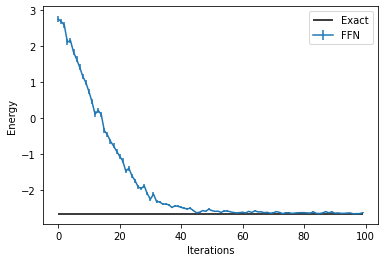

In [ ]:
data = log.data

plt.errorbar(data["Energy"].iters, data["Energy"].Mean, yerr=data["Energy"].Sigma, label="FFN")
#plt.hlines([E_gs_analytic], xmin=0, xmax=data["Energy"].iters.max(), color='black', label="Exact")
plt.hlines([eig_vals], xmin=0, xmax=data["Energy"].iters.max(), color='black', label="Exact")
plt.legend()

plt.xlabel('Iterations')
plt.ylabel('Energy')

### Wavefunctions

In [ ]:
ket = vstate.to_array()

ket

DeviceArray([ 4.48094259e-06-4.42933424e-07j,
             -4.47246002e-05-5.14152626e-05j,
             -6.35847623e-06-2.07838287e-06j,
              1.43870870e-07+2.80061797e-06j,
              1.41363810e-04+9.94959777e-05j,
              2.75205292e-04-9.25127316e-04j,
             -1.05314479e-04-2.22200141e-05j,
             -1.21471789e-05+2.01458061e-05j,
              2.19418886e-06-1.87331395e-05j,
             -3.41865667e-04+1.49179931e-04j,
             -9.71009718e-06+3.29754605e-06j,
              1.39299868e-05+1.18404414e-05j,
              3.07536311e-05-9.63725121e-06j,
             -1.56989462e-04-1.13678566e-04j,
             -1.15647218e-05-2.88649630e-06j,
             -2.70049349e-07+8.26365649e-06j,
              2.36257195e-05-8.23910182e-05j,
             -2.77582642e-04-1.69836626e-04j,
             -6.00868892e-05-1.95755711e-05j,
             -1.63371916e-05+1.52438411e-06j,
              6.55050497e-03-1.08747855e-03j,
              1.22178569e-02-1.494

In [ ]:
# get quantum geometric tensor of state
# https://github.com/netket/netket/blob/2a7dded3db4705099d4de5450006b46b32ce34ca/netket/optimizer/qgt/qgt_onthefly_logic.py
qgt = vstate.quantum_geometric_tensor()
qgt

QGTOnTheFly(diag_shift=0.0)

In [ ]:
QGT = qgt.to_dense()
jnp.imag(QGT)

DeviceArray([[0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             ...,
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.]], dtype=float64)

# The AKLT Model

The AKLT model is an extension to the simple 1D Heisenberg spin model, proposed in 1987 by Affleck, I. et al.:

https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.59.799

The model is essentially a 1D chain of spin-1/2 nuclei which form pairs. A constraint of having two spin-1/2 nuclei for each site is further imposed, which leads to the system being effectively a spin-1 system. This can be understood then to be a chain of these spin-1 "composite" nuclei. 

In the ground state of this Hamiltonian, every dimerized pair is referred to as a site and is given by a 

The AKLT Hamiltonian is given by a linear combination of the spin-1 projection operators in the respective Hilbert space $$\mathcal{H} \subset \mathbb{C}^3$$.